# RGI-07: Region 11 (Central Europe)
##### F. Roura-Adseiras, November 2021

Goal: same as RGI6

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
import numpy as np
from utils import mkdir

## Files and storage paths

In [2]:
# Region of interest
reg = 11

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# Izaguirre file for GLIMS check 
ref_reg_file_p = os.path.join(data_dir, 'l0_support_data', 'pyrenees2000.zip') 

# Frank file for GLIMS check 
ref_reg_file_a = os.path.join(data_dir, 'l0_support_data', 'C3S_GI_RGI11_L5_2003.zip') 

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '11_rgi60_CentralEurope.zip')

### Load the GLIMS input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions

In [4]:
toprint = []
for subid in shp.subm_id.unique():
    s_loc = shp.loc[shp.subm_id == subid]
    s = ''
    for c in ['subm_id', 'analysts', 'src_date']:
        toprint = s_loc[c].unique()
        if c != 'src_date':
            s += ' ' + (str(toprint[0]))
        else:
            for d in toprint:
                s += ' ' + d[:4]
    print(s)

 1.0 Taschner, Stefan 2001
 301.0 Taschner, Stefan 2003
 501.0 Iacovelli, Laura 2003
 531.0 Rott, Helmut; Schicker, Irene; Schwaizer (nee Bippus), Gabriele 2003
 532.0 Schicker, Irene; Schwaizer (nee Bippus), Gabriele 1985
 533.0 Paul, Frank 1998
 558.0 Vantadori, Federico 2007
 568.0 Rabatel, Antoine 2004 2003 2003
 569.0 Rabatel, Antoine 1988 1985 1985 1986 1987
 579.0 Fischer, Mauro 2009
 593.0 Paul, Frank 2003 2003 2003 2003 2003
 594.0 Wipf, Andreas 1850
 595.0 Maisch, Max 1850
 596.0 Fischer, Mauro 2008
 598.0 Paul, Frank 1999
 599.0 Benz, Christof; Wipf, Andreas 1973
 601.0 Fischer, Andrea; Kuhn, Michael; Lambrecht, Astrid 1969
 602.0 Fischer, Andrea; Kuhn, Michael; Lambrecht, Astrid 1998
 603.0 Fischer, Andrea 2012
 613.0 Fischer, Andrea 1850
 615.0 Smiraglia, Claudio 2011
 640.0 Antoine, Rabatel 2004
 641.0 Antoine, Rabatel 1971 1967 1970 1971 1949 1939
 663.0 Nemec, Johanna; Schwaizer (nee Bippus), Gabriele 2015
 664.0 Nemec, Johanna; Schwaizer (nee Bippus), Gabriele 2016
 66

## Apply selection criteria to reproduce RGI-7 for this region and check result

### Step 1: extract RGI7 from GLIMS data and do a check

In [5]:
# For Alps we use 'subm_id' = 731 as our main dataset
RGI_a = shp.loc[shp['subm_id'] == 731].copy()

# For Pyrenees we use 'subm_id' = 715 as our main dataset
RGI_p = shp.loc[shp['subm_id'] == 715].copy()

### Plot glaciers:

<AxesSubplot:>

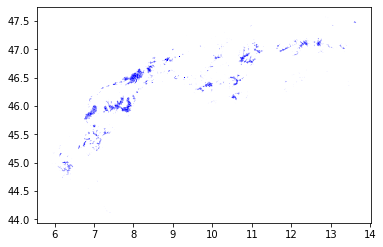

In [6]:
# Plot Alpine glaciers
RGI_a.geometry.plot(color='blue')

<AxesSubplot:>

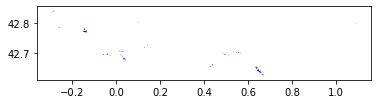

In [7]:
#Plot Pyrenean glaciers
RGI_p.geometry.plot(color='blue')

<AxesSubplot:>

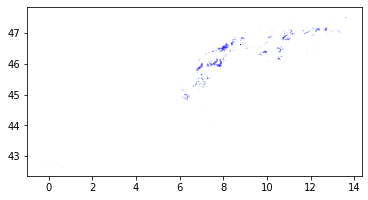

In [8]:
# Merge Pyrenees and Alps:
RGI_ss = pd.concat([RGI_a, RGI_p])
RGI_ss.geometry.plot(color='blue')

# Comparison to RGI7:

#### load reference Pyrenees data (here Izaguirre's)

In [9]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(ref_reg_file_p, "r") as z:
    for f in z.filelist:
        if 'glaciers_Pyrenees2000.shp' in f.filename:
            fname = f.filename
print(fname)
# load box
ref_odf_p = gpd.read_file('zip://' + ref_reg_file_p + '/' + fname)

glaciers_Pyrenees2000.shp


<AxesSubplot:>

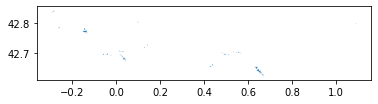

In [10]:
ref_odf_p.plot()

In [11]:
# add an area field to RGI_ss and reference data
RGI_p['area'] = RGI_p.to_crs({'proj':'cea'}).area
ref_odf_p['area'] = ref_odf_p.to_crs({'proj':'cea'}).area

In [12]:
print('Number of glaciers in new RGI subset:', len(RGI_p))
print('Number of glaciers in reference data (izaguirre):', len(ref_odf_p))
print('Difference:', len(RGI_p)-len(ref_odf_p))

Number of glaciers in new RGI subset: 47
Number of glaciers in reference data (izaguirre): 47
Difference: 0


In [57]:
# print and compare area values
Area_rgi = RGI_p['area'].sum()/1000000
print('Area RGI [km²]:', Area_rgi)
Area_ref = ref_odf_p['area'].sum()/1000000
print('Area ref:', Area_ref)
d = (Area_rgi - Area_ref)
d_perc = (d/Area_rgi*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area RGI [km²]: 4.200390629001659
Area ref: 2120.321066419914
Area difference [km²]: -2116.1206757909126 / percentage: -50379.14000617291


### For Pyrenees, not substantial differences between the original Izaguirre and RGI7 inventories. Now let's see the glaciers separately:

In [14]:
# go to every glacier differences
def area_check(new, ref):
    area_new = new['area'].sum()/1000000
    area_ref = ref['area'].sum()/1000000
    d = (area_new - area_ref)
    d_perc = (d/area_new*100)
    return d_perc, d

In [15]:
# Order glaciers from west to east:
ref = ref_odf_p.sort_values('CenLon')
new = RGI_p.sort_values('CenLon')

/tmp/ipykernel_155749/4134950988.py:6: RuntimeWarning: invalid value encountered in double_scalars
  d_perc = (d/area_new*100)


Text(0.5, 1.0, 'difference in area in km²')

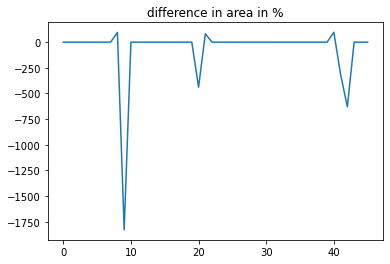

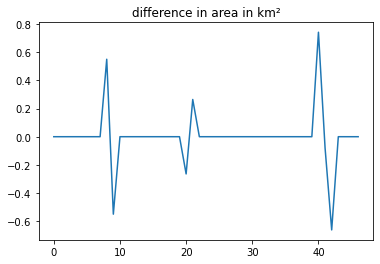

In [16]:
diff = []
for i in range(len(RGI_p)):
    diff.append(area_check(new[i+1:i+2], ref[i+1:i+2]))
    
df_diff = pd.DataFrame(diff)

plt.figure(0)
plt.plot(df_diff[0])
plt.title("difference in area in %")

plt.figure(1)
plt.plot(df_diff[1])
plt.title("difference in area in km²")

In [17]:
# errors in possible swaping of centroids between the 2 datasets (centroids differ)

In [18]:
# TODO: do the same but finding the closest pairs of centroids
#
#
#
#

### Load reference data (here Frank inventory)

In [50]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(ref_reg_file_a, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename:
            fname = f.filename
print(fname)
# load box
ref_odf_a = gpd.read_file('zip://' + ref_reg_file_a + '/' + fname)

c3s_gi_rgi11_l5_2003.shp


<AxesSubplot:>

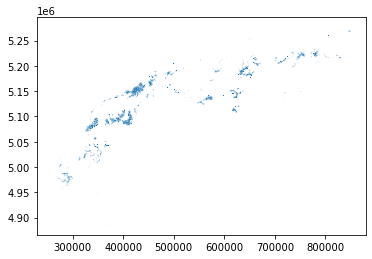

In [51]:
ref_odf_a.plot()

In [53]:
# add an area field to RGI_ss and reference data
RGI_a['area'] = RGI_a.to_crs({'proj':'cea'}).area
ref_odf_a['area'] = ref_odf_a.to_crs({'proj':'cea'}).area

In [54]:
print('Number of glaciers in new RGI subset:', len(RGI_a))
print('Number of glaciers in reference data (Franck):', len(ref_odf_a))
print('Difference:', len(RGI_a)-len(ref_odf_a))

Number of glaciers in new RGI subset: 4060
Number of glaciers in reference data (Franck): 4059
Difference: 1


In [56]:
# print and compare area values
Area_rgi = RGI_a['area'].sum()/1000000
print('Area RGI [km²]:', Area_rgi)
Area_ref = ref_odf_a['area'].sum()/1000000
print('Area ref:', Area_ref)
d = (Area_rgi - Area_ref)
d_perc = (d/Area_rgi*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area RGI [km²]: 2120.3198163438733
Area ref: 2120.321066419914
Area difference [km²]: -0.001250076040832937 / percentage: -5.895695692683182e-05


### For Alps, not substantial differences between the original Frank and glims inventories, except for a glacier, that we want to find now:

In [ ]:
# TODO: find missing glacier
#
#
#

# Comparison to RGI6:

#### load reference data (here RGI6) to enable comparison

In [20]:
# Just to know the name of the file to open from zip
import zipfile

with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename:
            fname = f.filename

# load reference data
ref_odf = gpd.read_file('zip://' + rgi6_reg_file + '/' + fname)

#### Number of elements entire region (differences do not necessarily depict major problems)

In [21]:
print('Number of glaciers in new RGI subset:', len(RGI_ss))
print('Number of glaciers in reference data (RGI06):', len(ref_odf))
print('Difference:', len(RGI_ss)-len(ref_odf))

Number of glaciers in new RGI subset: 4107
Number of glaciers in reference data (RGI06): 3927
Difference: 180


#### check for duplicate glacier IDs

In [22]:
print ('number of glaciers without unique id in RGI06:', len(ref_odf)-len(ref_odf['GLIMSId'].unique()))

number of glaciers without unique id in RGI06: 5


In [23]:
print ('number of glaciers without unique id in RGI06 from GLIMS data base:', len(RGI_ss)-len(RGI_ss['glac_id'].unique()))

number of glaciers without unique id in RGI06 from GLIMS data base: 0


#### Check for 'nominal glaciers' in the RGI6 original data and delete them from new RGI subset from GLIMS if they are in there 

In [24]:
# how many nominals in RGI06 (identifiable via 'Status' attribute in RGI 06)
nom = ref_odf.loc[ref_odf.Status == 2]
len(nom)

2

In [25]:
# drop nominal glaciers from new RGI subset
RGI_ss = (RGI_ss.loc[~RGI_ss['glac_id'].isin(nom['GLIMSId'])])

#### Total area

In [26]:
# add an area field to RGI_ss and reference data
RGI_ss['area'] = RGI_ss.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area
nom['area'] = nom.to_crs({'proj':'cea'}).area

/home/francesc/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [27]:
# print and compare area values
Area_Rep = RGI_ss['area'].sum()/1000000
print('Area Rep [km²]:', Area_Rep)
Area_RGI6 = ref_odf['area'].sum()/1000000
print('Area RGI6 [km²]:', Area_RGI6)
Area_nom = nom['area'].sum()/1000000
print('Area Nom [km²]:', Area_nom)
d = (Area_Rep + Area_nom - Area_RGI6)
d_perc = (d/Area_Rep*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area Rep [km²]: 2124.5202069728753
Area RGI6 [km²]: 2092.0679695469466
Area Nom [km²]: 0.16634799082587856
Area difference [km²]: 32.618585416754286 / percentage: 1.5353389113314628


## result of check (Alps + Pyrenees RGI from Glims global data base vs. RGI06 original):
#### difference in number of glaciers: 180
#### dublicate IDs: 5
#### nominal glaciers: 2
#### area difference: 33 km² (!!!) = 1.5%
#### general comment: how comes the area difference?

### Comparison gri6-gri7 Alps

In [28]:
# add an area field to RGI_ss and reference data
RGI_a['area'] = RGI_a.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area
nom['area'] = nom.to_crs({'proj':'cea'}).area

/home/francesc/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [29]:
# print and compare area values
Area_Rep = RGI_a['area'].sum()/1000000
print('Area Rep [km²]:', Area_Rep)
Area_RGI6 = ref_odf.loc[ref_odf["CenLon"] > 5.0]['area'].sum()/1000000
print('Area RGI6 [km²]:', Area_RGI6)
Area_nom = nom.loc[ref_odf["CenLon"] > 5.0]['area'].sum()/1000000
print('Area Nom [km²]:', Area_nom)
d = (Area_Rep + Area_nom - Area_RGI6)
d_perc = (d/Area_Rep*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area Rep [km²]: 2120.3198163438733
Area RGI6 [km²]: 2089.0828815401155
Area Nom [km²]: 0.16634799082587856
Area difference [km²]: 31.403282794583447 / percentage: 1.4810634958236162


In [30]:
# number of glaciers
print('Number of glaciers in new RGI subset:', len(RGI_a))
print('Number of glaciers in reference data (RGI06):', len(ref_odf.loc[ref_odf['CenLon'] > 5.0]))
print('Difference:', len(RGI_a)-len(ref_odf.loc[ref_odf['CenLon'] > 5.0]))

Number of glaciers in new RGI subset: 4060
Number of glaciers in reference data (RGI06): 3896
Difference: 164


**Summary Alps:**
* 164 glaciers difference
* 31 km² difference

### Comparison gri6-gri7 Pyrenees

In [31]:
# add an area field to RGI_ss and reference data
RGI_p['area'] = RGI_p.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area
nom['area'] = nom.to_crs({'proj':'cea'}).area

/home/francesc/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [32]:
# print and compare area values
Area_Rep = RGI_p['area'].sum()/1000000
print('Area Rep [km²]:', Area_Rep)
Area_RGI6 = ref_odf.loc[ref_odf["CenLon"] < 5.0]['area'].sum()/1000000
print('Area RGI6 [km²]:', Area_RGI6)
Area_nom = nom.loc[ref_odf["CenLon"] < 5.0]['area'].sum()/1000000
print('Area Nom [km²]:', Area_nom)
d = (Area_Rep + Area_nom - Area_RGI6)
d_perc = (d/Area_Rep*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area Rep [km²]: 4.200390629001659
Area RGI6 [km²]: 2.985088006831708
Area Nom [km²]: 0.0
Area difference [km²]: 1.2153026221699514 / percentage: 28.933085741570714


In [33]:
# number of glaciers
print('Number of glaciers in new RGI subset:', len(RGI_p))
print('Number of glaciers in reference data (RGI06):', len(ref_odf.loc[ref_odf["CenLon"] < 5.0]))
print('Difference:', len(RGI_p)-len(ref_odf.loc[ref_odf['CenLon'] < 5.0]))

Number of glaciers in new RGI subset: 47
Number of glaciers in reference data (RGI06): 31
Difference: 16


**Summary Pyrenees:**

<span style="color:red"> Differences rgi6-gri7 are huge for Pyrenees </span>
* 16 glacier difference (47-31)
* ~30% area difference

## Write out and tar 

In [34]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
RGI_ss.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))## Write out and tar 

Writing...
Taring...
RGI11/
RGI11/RGI11.cpg
RGI11/RGI11.dbf
RGI11/RGI11.prj
RGI11/RGI11.shp
RGI11/RGI11.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI11.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI11'], returncode=0)


## Find missing glaciers (to be improved)

In [35]:
from utils import haversine
import numpy as np
import progressbar

In [36]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [37]:
df_ref = ref_odf.copy()
rgi7 = RGI_ss.copy()

In [38]:
# Remove nominal
df_ref = df_ref.loc[df_ref.Status != 2].copy()

In [39]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()

coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

In [40]:
df_ref_orig = df_ref.copy()

In [41]:
# Loop over all RGI7 glaciers and find their equivalent in ref (rgi06)
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:10]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.001): # this filter is for area only... 
                                                          # It could be that the area between rgi6 and the new rgi7 datasets are greater than 
                                                          # this threshold. and this would result as "not found"
            found = True
            to_drop.append(s6.name)
            break
    if not found:
        not_found[i] = df_ref.iloc[np.argsort(dist)[:10]]
    if len(to_drop) > 1000:
        df_ref.drop(labels=to_drop, inplace=True)
        to_drop = []
df_ref.drop(labels=to_drop, inplace=True)

100% (4107 of 4107) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


In [42]:
print(len(not_found), len(df_ref))

1267 1086


In [43]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]

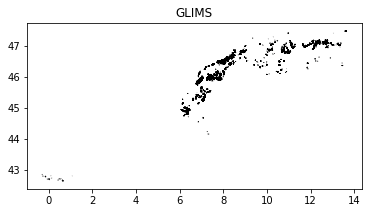

In [44]:
pb_rgi7.plot(edgecolor='k');
plt.title('GLIMS');

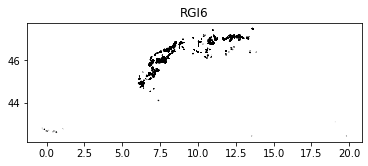

In [45]:
df_ref.plot(edgecolor='k');
plt.title('RGI6');

In [46]:
# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_problem_glaciers'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_problem_glaciers_tar'))

In [47]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
pb_rgi7.to_file(dd + f'RGI{reg:02d}_glims.shp')
df_ref.to_file(dd + f'RGI{reg:02d}_ref.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

OSError: [Errno 39] Directory not empty: '../../rgi7_data/l3_problem_glaciers/RGI11/'